In [1]:
!pip install lazypredict-nightly

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
import time
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [ ]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2024-12-09 04:28:50--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.008s  

2024-12-09 04:28:50 (40.0 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2024-12-09 04:28:50--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [7]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [8]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [9]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

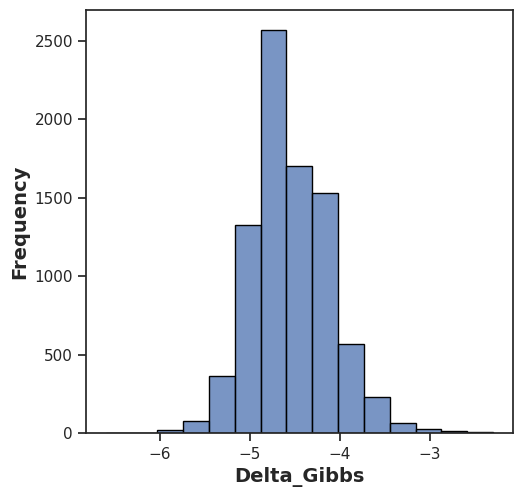

In [10]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

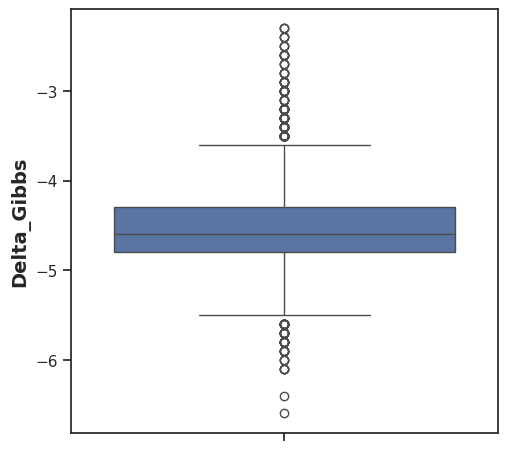

In [11]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

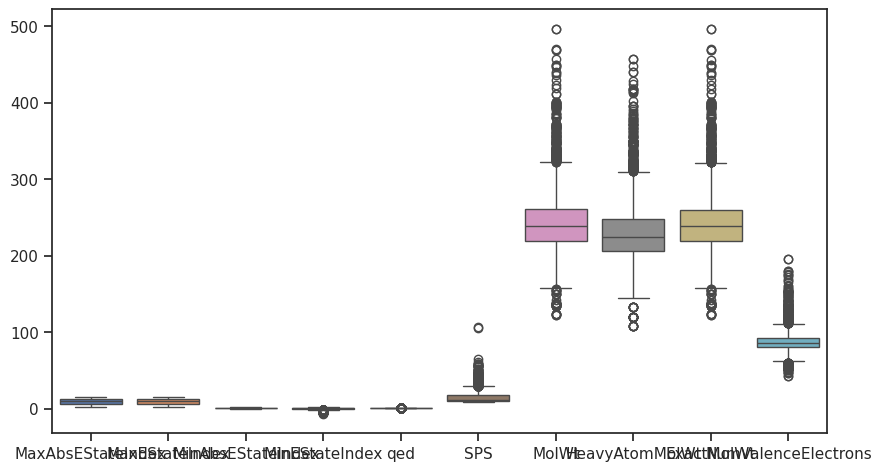

In [12]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

### Data Cleaning

In [13]:
RDKit_df.shape

(8515, 210)

In [14]:
# Drop columns with NaN
RDKit_df = RDKit_df.dropna(axis='columns')
RDKit_df.shape

(8515, 210)

### Data Transformation

In [15]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [16]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_df)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)

In [17]:
# Create RDKit scaled DataFrame
RDKit_columns = RDKit_df.columns
RDKit_scaled_df = pd.DataFrame(RDKit_scaled)
RDKit_scaled_df.columns = RDKit_columns
RDKit_scaled_df.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.03,0.01,0.00,0.01,0.00,0.01,0.00,0.03,0.00,0.00
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.08,0.09,0.06,0.08,0.01,0.11,0.02,0.10,0.02,0.02
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Merge descriptors dataframes with Delta Gibbs scores

In [18]:
RDKit = pd.concat([RDKit_scaled_df,df['Delta_Gibbs']], axis = 1)
RDKit

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Delta_Gibbs
0,0.77,0.77,0.28,0.40,0.82,0.07,0.41,0.44,0.41,0.38,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
1,0.72,0.72,0.21,0.40,0.76,0.03,0.32,0.35,0.32,0.23,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
2,0.76,0.76,0.24,0.39,0.89,0.03,0.42,0.44,0.42,0.39,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.20
3,0.67,0.67,0.03,0.76,0.61,0.02,0.29,0.32,0.29,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.50
4,0.76,0.76,0.13,0.37,0.95,0.06,0.41,0.45,0.41,0.36,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.59,0.01,0.82,0.96,0.04,0.48,0.51,0.48,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.90
8511,0.57,0.57,0.11,0.84,0.88,0.02,0.44,0.46,0.44,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
8512,0.63,0.63,0.01,0.82,0.76,0.03,0.48,0.51,0.48,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.70
8513,0.62,0.62,0.03,0.82,0.70,0.04,0.40,0.43,0.40,0.39,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.10


### Prepare the output/input dataframes

*   **Input:** PaDEL or RDKit descriptors
*   **Output:** pIC50 value

In [25]:
input = RDKit.iloc[:,:-1].copy()
output = RDKit.iloc[:,-1]

### Dimension Reduction Technique : PCA

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

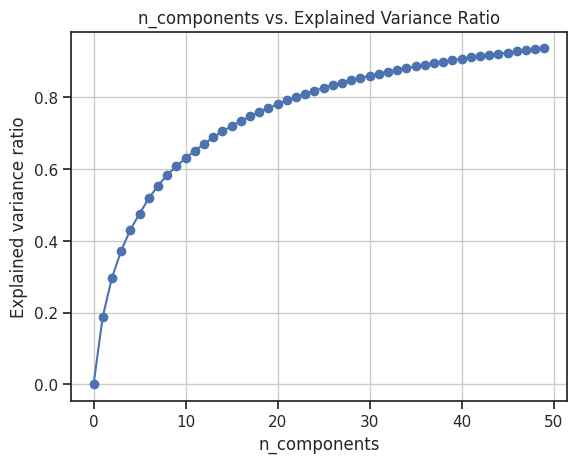

In [20]:
nums = np.arange(50)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(input)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [26]:
pca = PCA(n_components=50)
input = pca.fit_transform(input)

In [27]:
# Split the data to training and testing
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.30, random_state=3)

## Apply Machine Learning Algorithms

In [28]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

 98%|█████████▊| 41/42 [01:56<00:02,  2.43s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 5960, number of used features: 50
[LightGBM] [Info] Start training from score -4.540419


100%|██████████| 42/42 [01:57<00:00,  2.80s/it]


[(0.0, 1.0)]

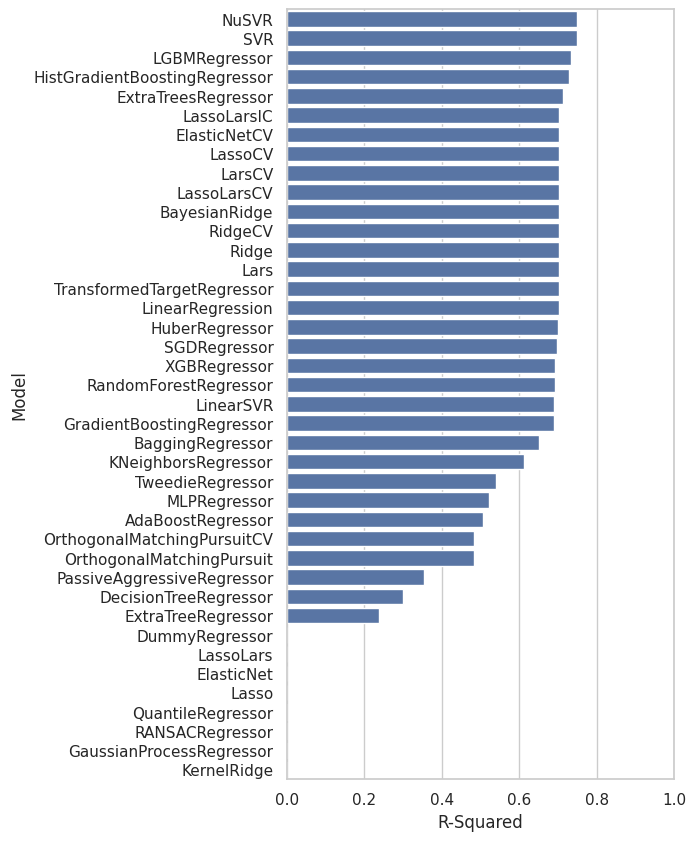

In [29]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="R-Squared", data=predictions)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

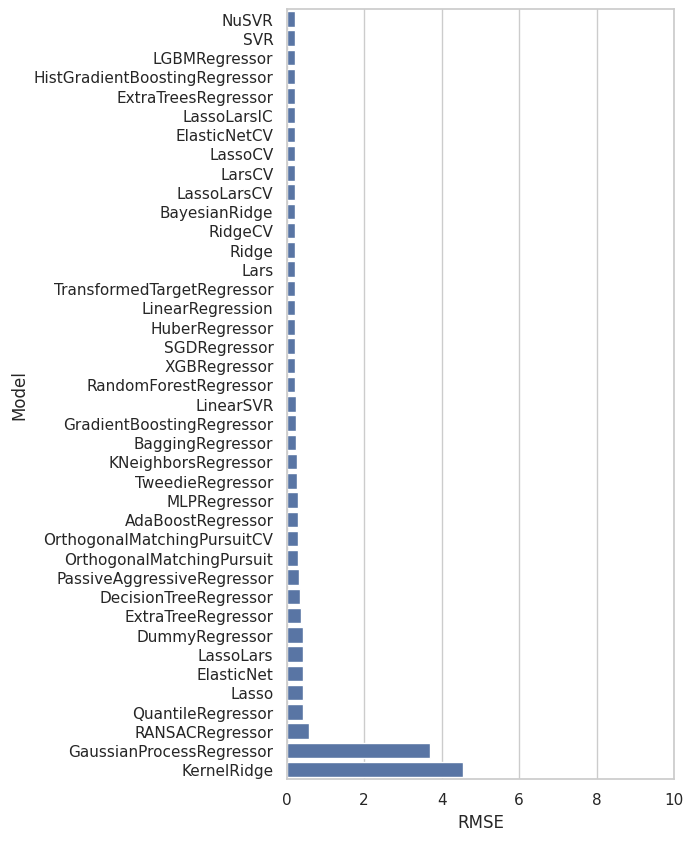

In [30]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="RMSE", data=predictions)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

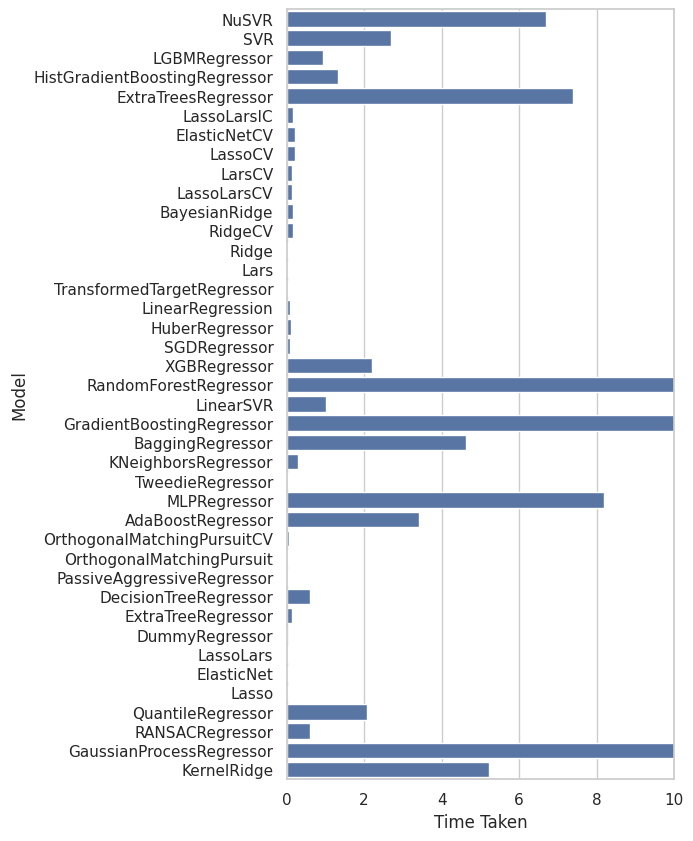

In [31]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="Time Taken", data=predictions)
ax.set(xlim=(0, 10))

In [ ]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

In [ ]:
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input, output, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
                   KernelRidge                        -234.07 [-317.6  -193.22 -175.85 -200.07 -283.59]
    TransformedTargetRegressor                           0.64 [0.65 0.72 0.66 0.6  0.56]
              LinearRegression                           0.64 [0.65 0.72 0.66 0.6  0.56]
                          Lars                           0.64 [0.65 0.72 0.66 0.6  0.56]
                   LassoLarsIC                           0.64 [0.65 0.72 0.66 0.6  0.56]
      GaussianProcessRegressor                         -11.76 [ -3.12 -12.02  -7.99 -18.4  -17.26]
                  MLPRegressor                           0.69 [0.79 0.75 0.72 0.64 0.53]
               RANSACRegressor                          -0.82 [-1.81 -0.42 -0.38  0.28 -1.76]
    PassiveAggressiveRegressor                           0.09 [ 0.22 -0.15 -0.2   0.27  0.31]
         DecisionTreeRegressor                           0.16 [0.24 0.27 0.15 0.06 0.06]
     Gradient